# Minitab: Engine, Not Interface

General Tips on using Minitab programmatically

# [Example Applications](#example)
- **Dashboard Example powered by Minitab's Engine**
- **Minitab inside Excel Application**
- **Customized Minitab Add-in**
___

# [Minitab's API: Quick Start](#quickstart)
- **Launch Minitab**
- **Control User Interface**
- **Send Data to Minitab**
- **Run Commands in Minitab**
- **Get Data from Minitab**
- **Retrieve Output from Minitab**
___

# [Create Word Report with Minitab](#wordreport)

- **Demo**
- **Get all Excel files from Directory**
- **Create Macro without knowing Minitab Command Language**
- **Send Output to Microsoft Word**
___

# [Analyze Mutual Fund Returns with Minitab](#stocks)

- **Pull Data from Internet**
- **Send data to Minitab**
- **Analyze returns in Minitab**
___

# [Creating an Excel Function that uses Minitab](#excel)

- **Create Excel Function**
- **Send data to Minitab**
- **Create I-Chart in Minitab**
- **Paste Graph in Excel**
___


<a id='quickstart'></a>
## Minitab's API: Quick Start

### What is an API?
API stands for Application Programming Interace.  This allows programmatic control over the application.

Many Desktop and Web Applications have API's.  For example:
* Twitter
* Yelp
* Microsoft Office (Word, PowerPoint, Excel)
* And numerous others

### Launch Minitab

In [1]:
import win32com.client as client
mtb = client.Dispatch('Mtb.Application')
ui = mtb.UserInterface
project = mtb.ActiveProject
sheet = project.ActiveWorksheet
commands = project.Commands
execute = project.ExecuteCommand

### Control User Interface

In [4]:
# Toggle if you want Minitab to be Visible or not
ui.Visible = True

### Send Data to Minitab

In [5]:
import numpy as np
data = np.random.normal(0,1,size = 20).tolist()
print(data)

[0.8753861206328731, 0.5161499082637366, -2.4130401714580705, -0.006309318327902019, 0.3505115155086413, -1.641211834617457, 0.8197634506673382, 1.2887457395659607, 1.0665753557777646, -0.4062238079235458, -0.9795621698670592, 1.229835371824156, 1.4725502553135044, 0.5440953414442861, -0.3979942574422113, -0.7063331745734708, -1.85424695265871, -0.7459691780286564, -1.3076352868356016, -0.785618112379786]


In [6]:
mtb_column = sheet.Columns.Add()
mtb_column.Name = "Data"
mtb_column.SetData(data)

### Run Commands in Minitab

In [7]:
execute('normtest c1; spvalue c2.')

### Get Data from Minitab

In [8]:
p_val = sheet.Columns.Item(2).GetData(1, 1)
print(p_val)

0.528


### Retrieve Output from Minitab

In [9]:
mtb_graph = commands.Item(1).Outputs.Item(1).Graph
mtb_graph.SaveAs(r'C:\Insights\normality', True, 1, 720,480)

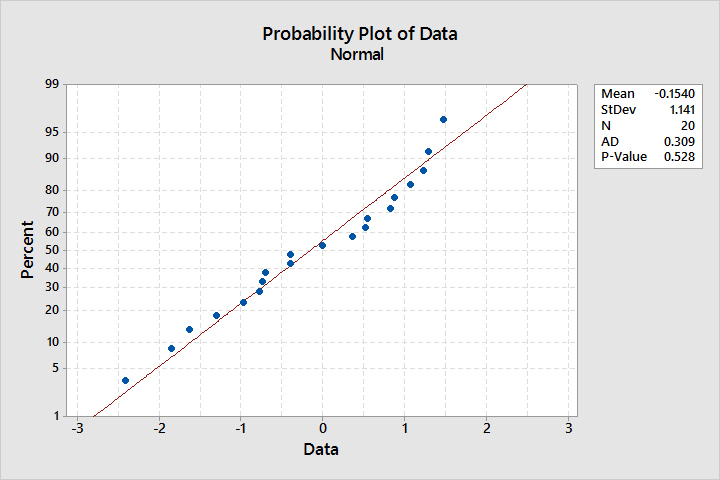

In [10]:
from IPython.display import Image
Image(r'C:\Insights\normality.jpg')

<a id='wordreport'></a>
## Create Microsoft Word Report with Minitab
Goal is to loop through each Excel file in a directory and create a report in Microsoft Word for with Minitab Output

*Note: a couple helper functions are provided to make this process a little easier*

In [11]:
from insights import (create_macro_template, get_files_in_dir, 
                      write_macro_to_file, close_mtb)
from os.path import join, basename, splitext
# paths are used to determine the directory's for certain files
path_to_graphs = r'C:\Insights\Graphs'
path_to_data = r'C:\Insights\Data'
path_to_reports = r'C:\Insights\Reports'

Let's first close Minitab

In [12]:
close_mtb()

### Demo

Quick Demo to show the final product that we will be building

### Get all Excel files from a Directory

In [13]:
excel_files = get_files_in_dir(path_to_data, suffix='xlsx')

In [14]:
excel_files

['C:\\Insights\\Data\\Depth.xlsx',
 'C:\\Insights\\Data\\Height.xlsx',
 'C:\\Insights\\Data\\Length.xlsx',
 'C:\\Insights\\Data\\Width.xlsx']

### Create a Macro without knowing Minitab Command Language

In [15]:
# launch Minitab
mtb = client.Dispatch('Mtb.Application')
ui = mtb.UserInterface
project = mtb.ActiveProject
commands = project.Commands
execute = project.ExecuteCommand

In [16]:
# toggle if Minitab should be visible
ui.Visible = True

In [17]:
# toggle if Minitab should popup alerts
ui.DisplayAlerts = False

### Open Data in Minitab
- Go to **File > Open**
- Browse to *Depth.xlsx* and click **Open** then **OK**

### Create I-Chart
- Go to **Stat > Control Charts > Variables Charts for Individuals > Individuals**
- Type *C2* in Variables
- Click **Scale**, check **Stamp** and under Stamp columns type C1
- Click **OK** and **OK**

### Create Tolerance Interval
- Go to **Stat > Quality Tools > Tolerance Intervals**
- Type *C2*
- Click **OK**

Let's look to see the Minitab Command Language that was generated

In [18]:
for i in range(1, commands.Count + 1):
    print(commands.Item(i).CommandLanguage)

WOPEN "C:\Insights\Data\Depth.xlsx"; FTYPE; EXCEL; DATA; IGNOREBLANKROWS; EQUALCOLUMNS; SHEET 1; VNAMES 1; FIRST 2; NROWS 50. 
ICHART c2; STAMP c1; DISPLAY 25. 
TOLINTERVALS c2; GTIPLOT; CONFIDENCE 95.0; PPERCENT 95.0. 


#### The Command Language is fine we just need to replace the path to the excel file

In [19]:
macro=create_macro_template(commands)

In [20]:
print(macro)

WOPEN '{filename}';
 FTYPE;
 EXCEL;
 DATA;
 IGNOREBLANKROWS;
 EQUALCOLUMNS;
 SHEET 1;
 VNAMES 1;
 FIRST 2.
ICHART c2;
 STAMP c1;
 DISPLAY 25. 
TOLINTERVALS c2;
 GTIPLOT;
 CONFIDENCE 95.0;
 PPERCENT 95.0. 


In [21]:
write_macro_to_file(r'C:\Insights\Macros\spc.txt', macro)

File Saved!


In [22]:
# read macro file
with open(r'C:\Insights\Macros\spc.txt', 'r') as f:
    macro = f.read()

In [23]:
# loop through all excel files
for file in excel_files:
    commands.Delete()
    # run Minitab commands on that Excel File
    execute(macro.format(filename=file))
    # save the graph 
    for i in range(1,commands.Count+1):
        for output in commands.Item(i).Outputs:
            if output.OutputType==0: # 0 Output type is a graph
                variable_name = splitext(basename(file))[0]
                fname = join(path_to_graphs, commands.Item(i).CommandLanguage[:5] + '_' + variable_name)
                output.Graph.SaveAs(fname, True, 1)

In [24]:
close_mtb()

### Using Microsoft Word's API

In [25]:
word = client.Dispatch('Word.Application')

In [26]:
word.Visible = True

In [28]:
doc=word.Documents.Open(r'C:\Insights\Reports\template\quality_report_template.docx')

In [29]:
var_bmark = doc.Bookmarks("variable_name").Range.Text = "Depth"

In [30]:
cchart_bmark = doc.Bookmarks('cc_chart').Range.InlineShapes.AddPicture(r'C:\Insights\Graphs\ICHAR_depth.jpg')

In [31]:
tol_bmark =doc.Bookmarks('tol_int').Range.InlineShapes.AddPicture(r'C:\Insights\Graphs\TOLIN_depth.jpg')

In [32]:
doc.SaveAs(r'C:\Insights\Reports\depth.docx')

In [33]:
doc.Close()

### Function to Create Report

In [34]:
def create_report(word_app, var_name, path_to_report, path_to_graphs):
    doc = word_app.Documents.Open(join(path_to_report, 'template','quality_report_template.docx'))
    varname = doc.Bookmarks("variable_name").Range.Text = var_name
    cchart = doc.Bookmarks('cc_chart').Range.InlineShapes.AddPicture(join(path_to_graphs, 'ICHAR_' + var_name) + '.jpg')
    tchart = doc.Bookmarks('tol_int').Range.InlineShapes.AddPicture(join(path_to_graphs, 'TOLIN_' + var_name) + '.jpg')
    doc.SaveAs(join(path_to_report, var_name + '.docx'))
    doc.Close()

### Loop through Excel files and create report

In [35]:
for file in excel_files:
    variable_name = splitext(basename(file))[0]
    create_report(word, variable_name, path_to_reports, path_to_graphs)
word.Quit
del word

## Analyze Mutual Fund Returns

In [36]:
from yahoo_finance import Share
import pandas as pd
start = '2016-01-01'
end = '2016-09-12'

In [37]:
def get_finance_data(symbol, start, end):
    data = Share(symbol)
    prices = data.get_historical(start, end)
    df = pd.DataFrame(prices)
    df.drop(['Symbol', 'Low', 'High', 'Open', 'Close', 'Volume'], inplace=True, axis=1)
    stocks = df.sort_values('Date')
    stocks[['Adj_Close']] = stocks[['Adj_Close']].astype(float)
    stocks['Percent_Change'] = stocks.Adj_Close/stocks.iloc[0,0]
    stocks[['Percent_Change']] = stocks[['Percent_Change']].astype(float) -1
    return stocks

In [38]:
my401k = get_finance_data('TRRKX', start, end)
my401k.tail()

,Adj_Close,Date,Percent_Change
4,16.330000,2016-09-06,0.094504
3,16.330000,2016-09-07,0.094504
2,16.350000,2016-09-08,0.095845
1,16.320000,2016-09-09,0.093834
0,16.129999,2016-09-12,0.081099


In [39]:
myReturns = [float(x) for x in my401k.Percent_Change.tolist()]
date = my401k.Date.tolist()

### Send the Data to Minitab to View

In [40]:
mtb = client.Dispatch('Mtb.Application')
project = mtb.ActiveProject
sheet = project.ActiveWorksheet
ui = mtb.UserInterface

In [41]:
ui.Visible = True

In [42]:
mtb_401k = sheet.Columns.Add()
mtb_401k.Name = "My 401k"
mtb_401k.SetData(myReturns)
mtb_date = sheet.Columns.Add()
mtb_date.Name = "Date"
mtb_date.SetData(date)

In [43]:
close_mtb()